# Title

In [133]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Constants
x = 'Price_cme_delta'
y1 = 'Price_eth_delta'
y2 = 'Price_steth_delta'

### Functions

In [134]:
def show_scatters(df1, df2, tf):

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.regplot(x=x, y=y1, data=df1, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
    sns.scatterplot(x=x, y=y1, data=df1)
    plt.title(f'ETH Futures vs. ETH')
    plt.xlabel('ETH Futures')
    plt.ylabel('ETH')

    plt.subplot(1, 2, 2)
    sns.regplot(x=x, y=y2, data=df2, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
    sns.scatterplot(x=x, y=y2, data=df2)
    plt.title(f'ETH Futures vs. stETH')
    plt.xlabel('ETH Futures')
    plt.ylabel('stETH')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # space for global title
    plt.suptitle(f'Scatter Plot of Correlation (deltas) on {tf} timeframe', fontsize=16, fontweight='bold')

    plt.show()

### Data Loading

In [135]:
col_names = ['Entry Date UTC', 'Price']

# Load CME ETH data [from CME Group]
df_cme_1m = pd.read_csv('../data/cme/cme_1m_cme.csv', usecols=col_names)
df_cme_1m['Entry Date UTC'] = pd.to_datetime(
        df_cme_1m['Entry Date UTC'],
        format='%Y%m%dT%H:%M:%S',
        utc=True
    )
df_cme_1m.set_index('Entry Date UTC', inplace=True)
df_cme_1h = df_cme_1m[df_cme_1m.index.minute == 0].reset_index()

# Load ETH data [from Trading View]
df_eth_1h = pd.read_csv('../data/eth/eth_1h_tv.csv', usecols=col_names)
df_eth_1h['Entry Date UTC'] = pd.to_datetime(df_eth_1h['Entry Date UTC'], utc=True)

# Load stETH data [from Trading View]
df_steth_1h = pd.read_csv('../data/steth/steth_1h_tv.csv', usecols=col_names)
df_steth_1h['Entry Date UTC'] = pd.to_datetime(df_steth_1h['Entry Date UTC'], utc=True)


### Data Processing

In [136]:
df_cme_eth = pd.merge(df_cme_1h, df_eth_1h, on='Entry Date UTC', suffixes=('_cme', '_eth'))
df_cme_steth = pd.merge(df_cme_1h, df_steth_1h, on='Entry Date UTC', suffixes=('_cme', '_steth'))

def calc_deltas(df, price_cols):
    for col in price_cols:
        df[f'{col}_delta'] = df[col].diff()
        df[f'{col}_return'] = df[col].pct_change()

calc_deltas(df_cme_eth, ['Price_cme', 'Price_eth'])
calc_deltas(df_cme_steth, ['Price_cme', 'Price_steth'])


### Correlation Analysis

In [143]:
# Correlations
corr_cme_eth = df_cme_eth['Price_cme_return'].corr(df_cme_eth['Price_eth_return'])
corr_cme_steth = df_cme_steth['Price_cme_return'].corr(df_cme_steth['Price_steth_return'])

# Rolling Correlations
window_size = 24  # 24 data points for 24 hours
df_cme_eth['rolling_corr'] = df_cme_eth['Price_cme_return'].rolling(window=window_size).corr(df_cme_eth['Price_eth_return'])
df_cme_steth['rolling_corr'] = df_cme_steth['Price_cme_return'].rolling(window=window_size).corr(df_cme_steth['Price_steth_return'])

print(f'cme eth vs. eth \n 1h corr: {f"{corr_cme_eth * 100:.2f}%"}\n')
print(f'cme steth vs. eth \n 1h corr: {f"{corr_cme_steth * 100:.2f}%"}\n')

#todo: make it a table and possibly add 1' & 5'

cme eth vs. eth 
 1h corr: 98.09%

cme steth vs. eth 
 1h corr: 71.20%



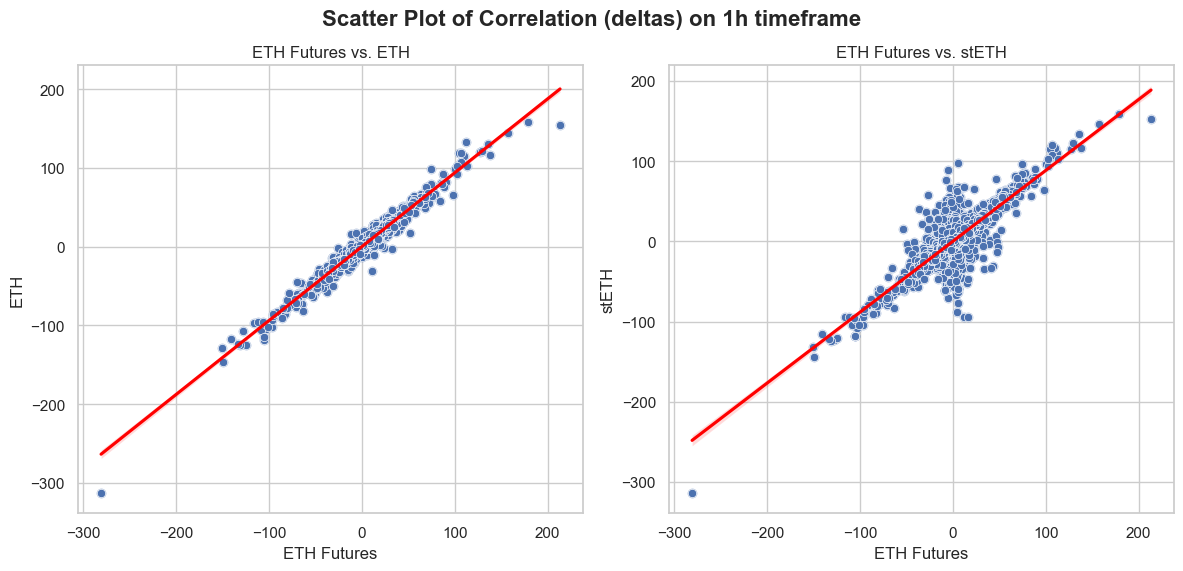

In [138]:
show_scatters(df_cme_eth, df_cme_steth, '1h')

In [177]:
import matplotlib.pyplot as plt

def show_rolling_correlations(df1, df2):
    plt.figure(figsize=(12, 6))
    plt.plot(df1['Entry Date UTC'], df1['rolling_corr'], label='ETH Futures vs. ETH', color='#1f77b4', linewidth=2)
    plt.plot(df2['Entry Date UTC'], df2['rolling_corr'], label='ETH Futures vs. stETH', color='#ff7f0e', linewidth=1, alpha=0.6)
    plt.title('Rolling Correlation Over Time (hourly intervals)', fontsize=16, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()


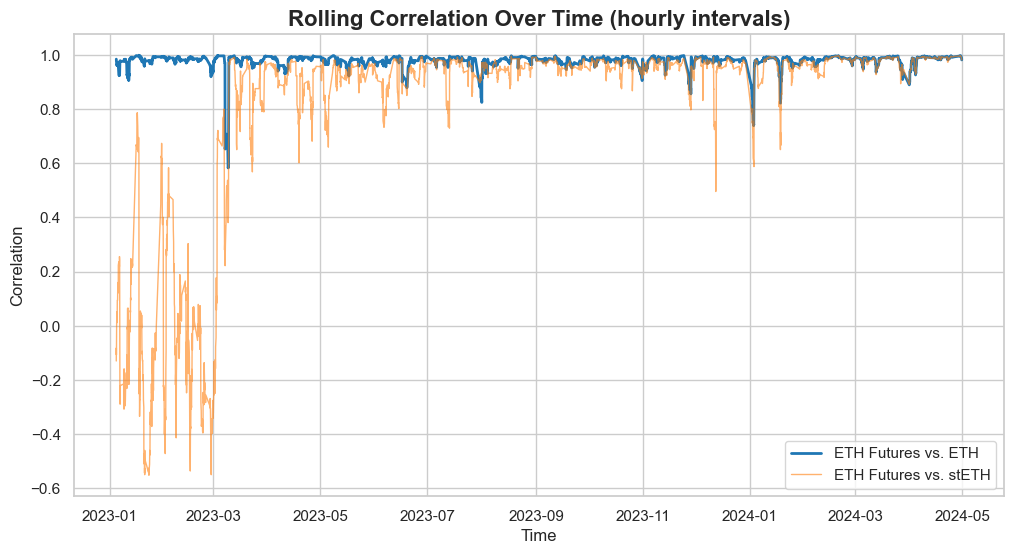

In [178]:
show_rolling_correlations(df_cme_eth, df_cme_steth)